In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.backends.backend_pdf
np.set_printoptions(precision=2)

In [2]:
N = 2000
BUFFER_SIZE = 10000
BATCH_SIZE = 200
learning_rate = 0.0001
n_layers = 10
n_units = 20
epochs = 10000

In [3]:
data = np.load('data/drained_top_and_bottom.npz')
z = data['z'].flatten()[:,None]
t = data['t'].flatten()[:,None]
u_anasol = np.real(data['u']).T

# Create meshgrid
Z, T = np.meshgrid(z, t)
zt_grid = np.hstack((Z.flatten()[:,None], T.flatten()[:,None]))
u_grid = u_anasol.flatten()[:,None]

# Get (z,t) bounds
zt_min = zt_grid.min(0)
zt_max = zt_grid.max(0)

#zt_bndry = np.hstack((Z[:,-1:], T[:,-1:]))
#u_bndry = u_anasol[:,-1:]
#print(zt_bndry.shape)

# Sample data
idx = np.random.choice(zt_grid.shape[0], N, replace=False)
zt_sample = zt_grid[idx,:]
print(zt_sample.shape)
#zt_sample = np.vstack((zt_sample, zt_bndry))
print(zt_sample.shape)
u_sample = u_grid[idx,:]
#u_sample = np.vstack((u_sample, u_bndry))

# Create training data
z_train = tf.convert_to_tensor(zt_sample[:,0:1], dtype=tf.float32)
t_train = tf.convert_to_tensor(zt_sample[:,1:2], dtype=tf.float32)
u_train = tf.convert_to_tensor(u_sample, dtype=tf.float32)
print(z_train.shape, t_train.shape, u_train.shape)

#zt_train = tf.concat([z_train, t_train], axis=1)
train_ds = tf.data.Dataset.from_tensor_slices(
    (z_train, t_train, u_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(2000, 2)
(2000, 2)
(2000, 1) (2000, 1) (2000, 1)


In [4]:
layers = []
for i in range(n_layers):
    if i == 0:
        layer = tf.keras.layers.Dense(n_units, activation='tanh', input_dim=2)
    else:
        layer = tf.keras.layers.Dense(n_units, activation='tanh')
    layers.append(layer)      

output_layer = tf.keras.layers.Dense(1)
layers.append(output_layer)

model = tf.keras.Sequential(layers)

cv_weight_init = 0.0
init = tf.compat.v1.keras.initializers.Constant(cv_weight_init, dtype=tf.float32)
model.layers[-1].add_weight(name='cvw', initializer=init, trainable=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
u_loss = tf.keras.metrics.Mean(name='u_loss')
f_loss = tf.keras.metrics.Mean(name='f_loss')
cv_loss = tf.keras.metrics.Mean(name='cv_loss')

In [5]:
@tf.function
def train_step(zt, tt, ut):
    with tf.GradientTape() as tape0:                     
        with tf.GradientTape() as tape1:
            tape1.watch(zt)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(zt)
                tape2.watch(tt)
                u_pred = model(tf.concat([zt, tt], axis=1), training=True)                            
            dudt = tape2.gradient(u_pred, tt)
            dudz = tape2.gradient(u_pred, zt)            
        d2udz2 = tape1.gradient(dudz, zt)         
        cv_weight = model.layers[-1].trainable_weights[-1]
        cv = tf.exp(cv_weight)
        f = dudt - cv * d2udz2        
        mse_u = tf.reduce_mean(tf.square(ut - u_pred))
        mse_f = tf.reduce_mean(tf.square(f))
        mse = mse_u + mse_f        
        #print(cv)                 
    grads = tape0.gradient(mse, model.trainable_variables)    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))    
    train_loss(mse)
    u_loss(mse_u)
    f_loss(mse_f)
    cv_loss(cv)    
    return mse

In [6]:
mse, mse_u, mse_f, cv_pred = [], [], [], []
for epoch in range(epochs):
    train_loss.reset_states()
    u_loss.reset_states()
    f_loss.reset_states()
    cv_loss.reset_states()
    for zt, tt, ut in train_ds:                
        train_step(zt, tt, ut)
    template = 'Loss: {} cv: {}'
    print(template.format(train_loss.result(), cv_loss.result()))    
    mse.append(train_loss.result())
    mse_u.append(u_loss.result())
    mse_f.append(f_loss.result())
    cv_pred.append(cv_loss.result())
print('Training completed!')

784584
Loss: 0.00010496706090634689 cv: 0.09934800118207932
Loss: 0.00013709849736187607 cv: 0.09934937953948975
Loss: 0.00013368827058002353 cv: 0.09935562312602997
Loss: 0.00013000445323996246 cv: 0.09934953600168228
Loss: 0.00010056167229777202 cv: 0.09934928268194199
Loss: 8.96310230018571e-05 cv: 0.09935011714696884
Loss: 8.195814734790474e-05 cv: 0.09935080260038376
Loss: 7.86383607191965e-05 cv: 0.09935023635625839
Loss: 7.93139188317582e-05 cv: 0.09934799373149872
Loss: 7.851162081351504e-05 cv: 0.0993492603302002
Loss: 7.771989476168528e-05 cv: 0.09934823960065842
Loss: 7.841606566216797e-05 cv: 0.09934757649898529
Loss: 8.499080286128446e-05 cv: 0.09934879839420319
Loss: 8.150649955496192e-05 cv: 0.0993531346321106
Loss: 7.60895200073719e-05 cv: 0.09935194998979568
Loss: 7.596352224936709e-05 cv: 0.09935015439987183
Loss: 8.399445505347103e-05 cv: 0.09934926778078079
Loss: 8.504949073540047e-05 cv: 0.09934908896684647
Loss: 0.00010043443035101518 cv: 0.0993509292602539
Loss: 

In [7]:
z_test = tf.convert_to_tensor(zt_grid[:,0:1], dtype=tf.float32)
t_test = tf.convert_to_tensor(zt_grid[:,1:2], dtype=tf.float32)

cv = cv_loss.result()

with tf.GradientTape() as tape3:
  tape3.watch(z_test)
  with tf.GradientTape(persistent=True) as tape4:
      tape4.watch(z_test)
      tape4.watch(t_test)
      u_test = model(tf.concat([z_test, t_test], axis=1))
  dudz = tape4.gradient(u_test, z_test)
  dudt = tape4.gradient(u_test, t_test)
d2udz2 = tape3.gradient(dudz, z_test)
f = dudt - cv * d2udz2

print('f min =', f.numpy().min())
print('f max =', f.numpy().max())
print('f mean =', f.numpy().mean())

f min = -0.10635519
f max = 0.04754114
f mean = -0.0014332185


Error u: 2.099567e-02


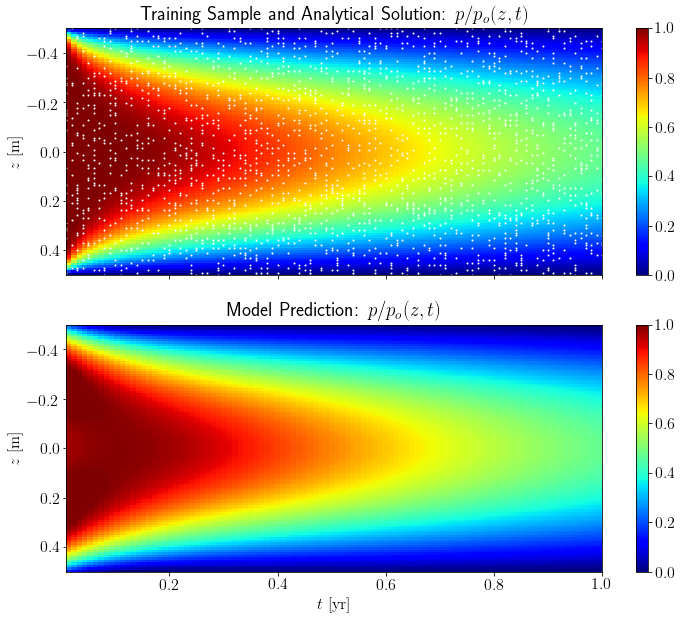

In [16]:
error_u = np.linalg.norm(u_grid - u_test, 2) / np.linalg.norm(u_grid, 2)
print('Error u: {:e}'.format(error_u))

u_test_grid = griddata(zt_grid, u_test.numpy().flatten(), (Z, T), method='cubic')
Error = np.abs(u_anasol - u_test_grid)

plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 16})

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10), sharex=True)
anasol = ax1.imshow(u_anasol.T, interpolation='nearest', cmap='jet',
          extent=[t.min(), t.max(), z.max(), z.min()],
          origin='lower', aspect='auto')
fig1.colorbar(anasol, ax=ax1)
ax1.plot(zt_sample[:,1], zt_sample[:,0], 'wo', markersize=1, fillstyle='none')
line = np.linspace(z.min(), z.max(), 2).reshape(-1, 1)

# t_idx = [1, 4, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
# for i in t_idx:
#     ax1.plot(t[i]*np.ones((2,1)), line, 'w--', linewidth=0.5)    
ax1.set_ylabel('$z~[\mathrm{m}]$')
ax1.set_title(r'Training Sample and Analytical Solution: $p/p_o(z,t)$')


pred = ax2.imshow(u_test_grid.T, interpolation='nearest', cmap='jet',
          extent=[t.min(), t.max(), z.max(), z.min()],
          origin='lower', aspect='auto', clim=(0,1))
fig1.colorbar(pred, ax=ax2)
# for i in t_idx:
#     ax2.plot(t[i]*np.ones((2,1)), line, 'w--', linewidth=0.5)
#     if i == 69:
#         ax2.text(t[i]+0.01, 0.6, '$t=$' + str(0.7), rotation=90)
#     else:
#         ax2.text(t[i]+0.01, 0.6, '$t=$' + str(t[i][0]), rotation=90)
ax2.set_xlabel('$t~[\mathrm{yr}]$')
ax2.set_ylabel('$z~[\mathrm{m}]$')
ax2.set_title(r'Model Prediction: $p/p_o(z,t)$')

plt.savefig('plots/color_plot_inverse_drained_top_and_bottom.pdf')

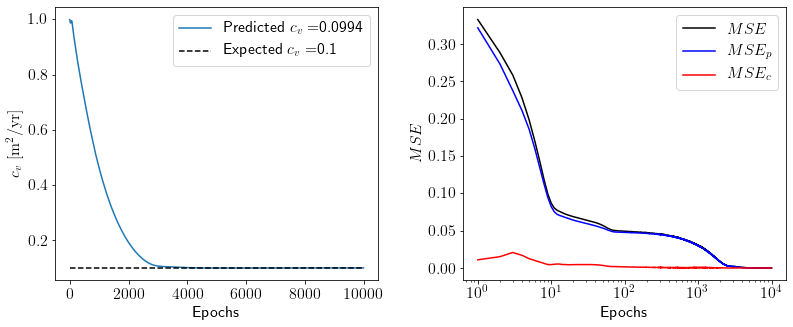

In [10]:
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,5.5))
fig2.tight_layout(pad=3.0)

# for i in t_idx:
#     ax3.plot(u_anasol[i:i+1,:].T, -z+1, 'b-', linewidth=2) #, label='Analytical t={:.2f}'.format(t[i][0]))
#     ax3.plot(u_test_grid[i:i+1,:].T, -z+1, 'r--', linewidth=2) #, label='Prediction t={:.2f}'.format(t[i][0]))
# #ax3.legend(frameon=False, loc='best')
# ax3.set_ylim(ax3.get_ylim()[::-1])
# ax3.set_xlabel('$p/p_o$')
# ax3.set_ylabel('$z~[\mathrm{m}]$')

ax3.plot(range(1, epochs+1), cv_pred, label='Predicted ' + '$c_{v}=$' + '{%.4f}' % cv_pred[-1].numpy())
ax3.set_xlabel('Epochs')
ax3.set_ylabel('$c_v~[\mathrm{m^2/yr}]$')
cv_line = np.linspace(1, epochs, 2).reshape(-1, 1)
ax3.plot(cv_line, 0.1*np.ones((2,1)), 'k--', label='Expected  ' + '$c_{v}=$' + str(0.1))
#ax3.text(5000, 0.65, 'Predicted ' + '$c_{v}=$' + '{%.4f}' % cv_pred[-1].numpy() )
#ax3.text(5000, 0.61, 'Expected  ' + '$c_{v}=$' + str(0.6))
ax3.legend(loc='best')

ax4.semilogx(range(1, epochs+1), mse, 'k-', label='$MSE$')
ax4.semilogx(range(1, epochs+1), mse_u, 'b-',  label='$MSE_p$')
ax4.semilogx(range(1, epochs+1), mse_f, 'r-', label='$MSE_c$')
ax4.legend(loc='best')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('$MSE$')

plt.savefig('plots/plots_inverse_drained_top_and_bottom.pdf')

In [11]:
model.save('saved_models/inverse_model_drained_top_and_bottom')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inverse_model_drained_top_and_bottom\assets
